In [1]:
!pip install pip==23.2.1 setuptools==65.5.1

In [2]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [3]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "train.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/train.csv


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [5]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [7]:
# Reduce memory

from numpy import float64, float32, int64, int32, dtype

map_dtypes = {
    'int': dtype(int64),
    'float': dtype(float32)
    }

for col in df:
    if df[col].dtype == dtype(int64):
        df[col] = df[col].astype(int32)
    if df[col].dtype == dtype(float64):
        df[col] = df[col].astype(float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int32  
 1   cont1   300000 non-null  float32
 2   cont2   300000 non-null  float32
 3   cont3   300000 non-null  float32
 4   cont4   300000 non-null  float32
 5   cont5   300000 non-null  float32
 6   cont6   300000 non-null  float32
 7   cont7   300000 non-null  float32
 8   cont8   300000 non-null  float32
 9   cont9   300000 non-null  float32
 10  cont10  300000 non-null  float32
 11  cont11  300000 non-null  float32
 12  cont12  300000 non-null  float32
 13  cont13  300000 non-null  float32
 14  cont14  300000 non-null  float32
 15  target  300000 non-null  float32
dtypes: float32(15), int32(1)
memory usage: 18.3 MB


In [8]:
df.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,249825.145857,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483927,0.506877,0.553442,0.503713,7.905662
std,144476.732562,0.203962,0.228142,0.200769,0.233030,0.220694,0.217906,0.181088,0.216215,0.196677,0.201846,0.220072,0.218942,0.229731,0.208236,0.733055
min,1.000000,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367,0.000000
25%,124656.500000,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673,7.329367
50%,249738.500000,0.484005,0.553209,0.551471,0.482880,0.451733,0.470987,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845,7.940571
75%,374836.250000,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653,8.470084
max,499999.000000,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049026,0.977845,0.868506,10.267569


In [9]:
df.shape

(300000, 16)

In [10]:
print(df.isnull().sum())
df.duplicated().sum()


id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64


0

In [11]:
# Drop non-numeric columns if any and separate features & target
X = df.drop(columns=['id', 'target'])  # Adjust according to dataset
y = df['target']

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 14), (60000, 14), (240000,), (60000,))

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



In [14]:
from pandas import DataFrame
X_train = DataFrame(scaler.fit_transform(X_train))
X_test = DataFrame(scaler.transform(X_test))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 14), (60000, 14), (240000,), (60000,))

# FInd Algorithem = LightGBM 

In [54]:
import time
import random
import math
import lightgbm as lgb  # Changed from catboost to lightgbm
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")  

In [56]:
# DEAP setup for GA (unchanged)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using LightGBM"""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'verbosity': -1,  # -1 means silent
        'seed': 42
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train.iloc[:, selected_indices], label=y_train)
    test_data = lgb.Dataset(X_test.iloc[:, selected_indices], label=y_test, reference=train_data)

    # Train model - note different parameter names
    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, test_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(0)  # Replaces verbose_eval
        ]
    )

    return mean_squared_error(y_test, model.predict(X_test.iloc[:, selected_indices]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [57]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm"""
    def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # a decreases linearly from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # a2 decreases linearly from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1  # Spiral constant
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        # Search for prey
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    # Bubble-net attacking
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate new solution
                fitness[i] = self.func(whales[i])

                # Update best
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness

In [58]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and elimination rounds."""
    def __init__(self, func, dim, lb, ub, n_players=30, max_games=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players with roles (0=defensive, 1=offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])
        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.2 + (0.5 * game / self.max_games)  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    # Aggressive move toward best player with momentum
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    # Local search with adaptive step size
                    step = np.random.normal(0, 0.5*(1-game/self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # Role adaptation
                if random.random() < 0.1:  # 10% chance to switch roles
                    roles[i] = 1 - roles[i]

            # Evaluate and apply elimination
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                # Survival condition
                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1*best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness

In [59]:
class PSH_Hyptrite:
    """Fixed implementation with bounds checking"""
    def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - iter/self.max_iter)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 3)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

In [60]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 30")
        print(f"- Generations: 20")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Changed to LightGBM

    # 2. Setup evolutionary toolbox 
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                    toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))  # Now uses LightGBM
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 3. Initialize population
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(20):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        if gen % 5 == 0 or gen == 19:
            print(f"Gen {gen+1:02d}/20 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence (LightGBM)')  # Updated title
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [61]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 30 particles")
        print(f"- Iterations: 20")
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Changed to LightGBM

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Now uses LightGBM

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 30 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=30,
        maxiter=20,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence (LightGBM)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [62]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 30 whales")
        print(f"- Max iterations: 20")
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Changed to LightGBM

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Now uses LightGBM
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)
                a2 = -1 + iter * (-1 / self.max_iter)

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    whales[i] = np.clip(whales[i], self.lb, self.ub)
                    fitness[i] = self.func(whales[i])

                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence (LightGBM)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }

In [63]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 30 (15 offensive, 15 defensive)")
        print(f"- Max games: 20")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using LightGBM \n")  # Changed from XGBoost to CatBoost

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Now uses CatBoost

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=30,
        max_games=20
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results (unchanged)
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis (unchanged except plot title)
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence (LightGBM )')  # Updated title
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [64]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization with LightGBM specification
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 30")
        print(f"- Max iterations: 20") 
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using LightGBM\n")  # Updated to LightGBM

    # 2. Setup bounds and tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. LightGBM evaluation function
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # LightGBM evaluation
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite optimizer (unchanged structure)
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3

        def hypersphere_sampling(self, center, radius, n_samples):
            """Efficient hypersphere sampling with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Prevent division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize with boundary checking
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                radius = initial_radius * (1 - iter/self.max_iter)  # Linear decay
                
                # Vectorized hypersphere sampling
                new_points = np.vstack([self.hypersphere_sampling(p, radius, self.hs_samples) 
                                    for p in points])
                
                # Parallel evaluation
                new_fitness = np.array([self.func(p) for p in new_points])

                # Elite selection
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]
                
                # Update best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Progress reporting
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                        end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Execute optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-processing with min 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)

    # 7. Results reporting
    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Enhanced visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence (LightGBM)')  # Cleaned title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [65]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb  # Changed from catboost to lightgbm
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name} with LightGBM...")  # Added LightGBM specification
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms using LightGBM"""
    plt.figure(figsize=(15, 10))
    plt.suptitle('Algorithm Comparison (LightGBM Evaluation)', y=1.02)  # Added main title

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'steelblue' for name in names]  # Improved colors
    bars = plt.bar(names, mses, color=colors)
    plt.title('Model Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    bars = plt.bar(names, times, color=colors)
    plt.title('Computational Efficiency')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    bars = plt.bar(names, feature_counts, color=colors)
    plt.title('Feature Selection Sparsity')
    plt.ylabel('Number of Selected Features')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            linewidth = 3 if name == best_algo_name else 1.5
            linestyle = '-' if name == best_algo_name else '--'
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=linewidth,
                    linestyle=linestyle)
    plt.title('Convergence Patterns')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Enhanced summary report
    print("\n" + "="*60)
    print("=== FINAL FEATURE SELECTION RESULTS USING LightGBM ===")
    print("="*60)
    
    # Best algorithm summary
    print(f"\n🏆 BEST ALGORITHM: {best_algo_name.upper()}")
    print(f"   • MSE: {results[best_algo_name]['mse']:.6f}")
    print(f"   • Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"   • Features: {len(results[best_algo_name]['features'])}/{X_train.shape[1]} "
          f"({100*(1 - len(results[best_algo_name]['features'])/X_train.shape[1]):.1f}% reduction)")
    
    # Full comparison table
    print("\n📊 COMPARISON TABLE:")
    print(f"{'Algorithm':<30}{'MSE':<15}{'Time (s)':<15}{'Features':<15}")
    print("-"*75)
    for name in sorted(results.keys(), key=lambda x: results[x]['mse']):
        print(f"{name:<30}{results[name]['mse']:<15.6f}{results[name]['time']:<15.2f}"
              f"{len(results[name]['features']):<15}")

    # Selected features
    print("\n🔍 SELECTED FEATURES:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")
    
    print("\n💡 Tip: Consider feature importance from LightGBM for further analysis")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm with LightGBM...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 30
- Generations: 20
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 14 features
- Target: Minimize MSE using LightGBM

[Evolution Progress]
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.491689	valid_1's l2: 0.498408
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.495427	valid_1's l2: 0.50123
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.503216	valid_1's l2: 0.508289
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.496002	valid_1's l2: 0.502169
Training until validation scores don't improve for 10 rounds
Did not meet early 

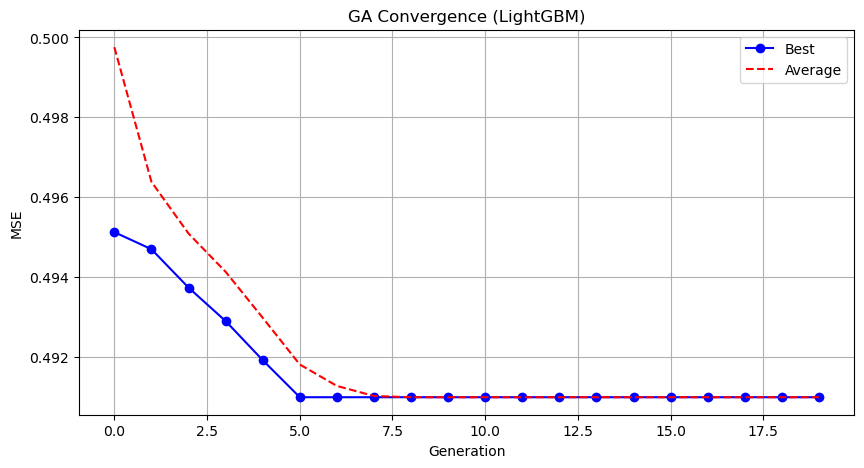

Genetic Algorithm completed successfully with MSE: 0.4910

Running Particle Swarm Optimization with LightGBM...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 14 features
- Target: Minimize MSE using LightGBM

[Optimization Progress]
No constraints given.
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.504654	valid_1's l2: 0.5099
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.498038	valid_1's l2: 0.503566
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.498666	valid_1's l2: 0.504321
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's

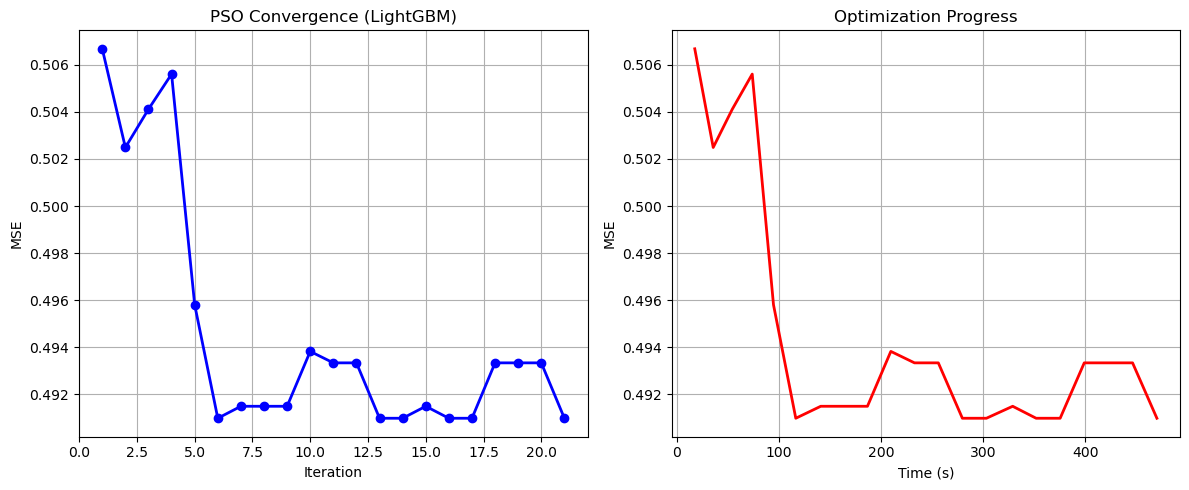

Particle Swarm Optimization completed successfully with MSE: 0.4910

Running Whale Optimization with LightGBM...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 30 whales
- Max iterations: 20
- Spiral coefficient (b): 1.0
- Search space: 14 features
- Target: Minimize MSE using LightGBM

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.508683	valid_1's l2: 0.512212
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.498238	valid_1's l2: 0.50427
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.502211	valid_1's l2: 0.507335
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.499801	valid_1's l2: 0.504613
Training until validation scores don't imp

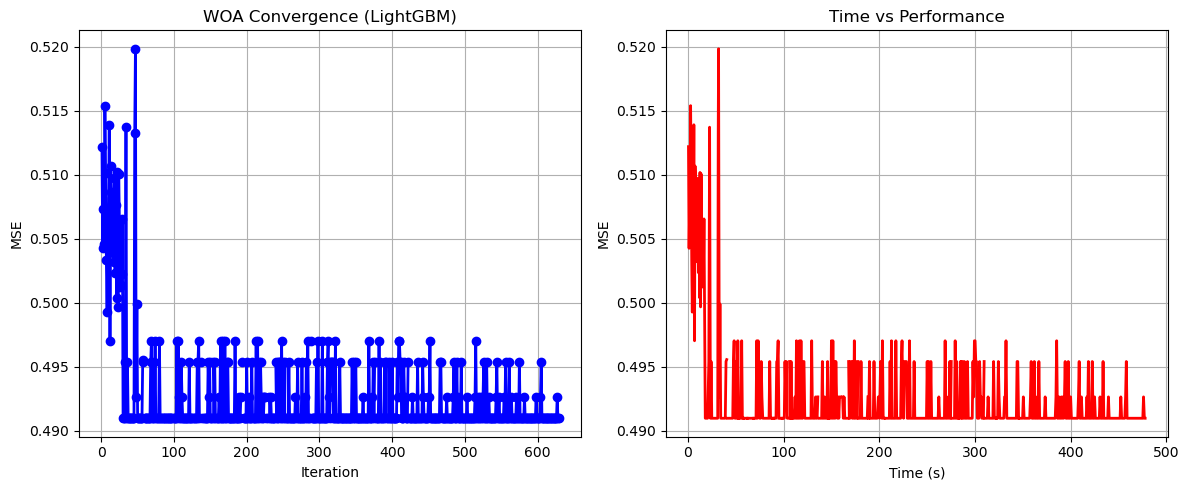

Whale Optimization completed successfully with MSE: 0.4910

Running Squid Game Optimizer with LightGBM...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 30 (15 offensive, 15 defensive)
- Max games: 20
- Search space: 14 features
- Target: Minimize MSE using LightGBM 

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	training's l2: 0.50432	valid_1's l2: 0.508176
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	training's l2: 0.504013	valid_1's l2: 0.508521
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.495278	valid_1's l2: 0.500674
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[97]	training's l2: 0.497598	valid_1's l2: 0.503156
Training until validation scores don't improve for 10 rounds
Did not 

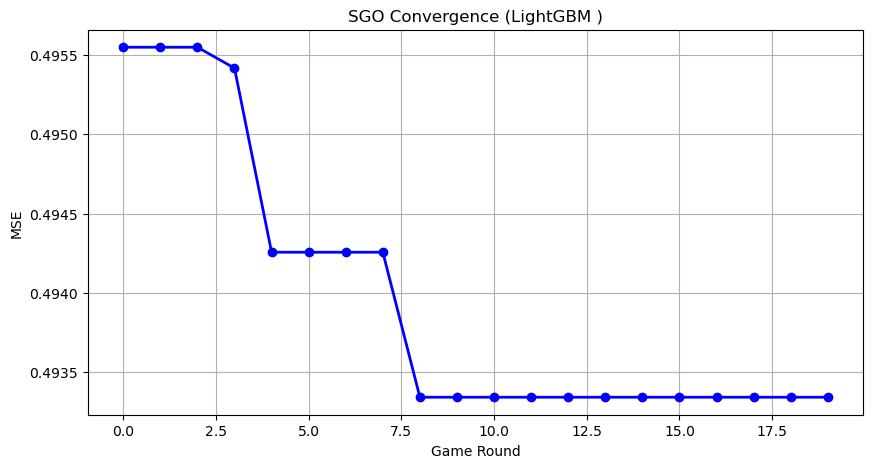

Squid Game Optimizer completed successfully with MSE: 0.4933

Running PSH-Hyptrite with LightGBM...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 14 features
- Target: Minimize MSE using LightGBM

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.492753	valid_1's l2: 0.498323
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.491276	valid_1's l2: 0.497397
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.499824	valid_1's l2: 0.504991
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	training's l2: 0.495409	valid_1's l2: 0.501364
Training until validatio

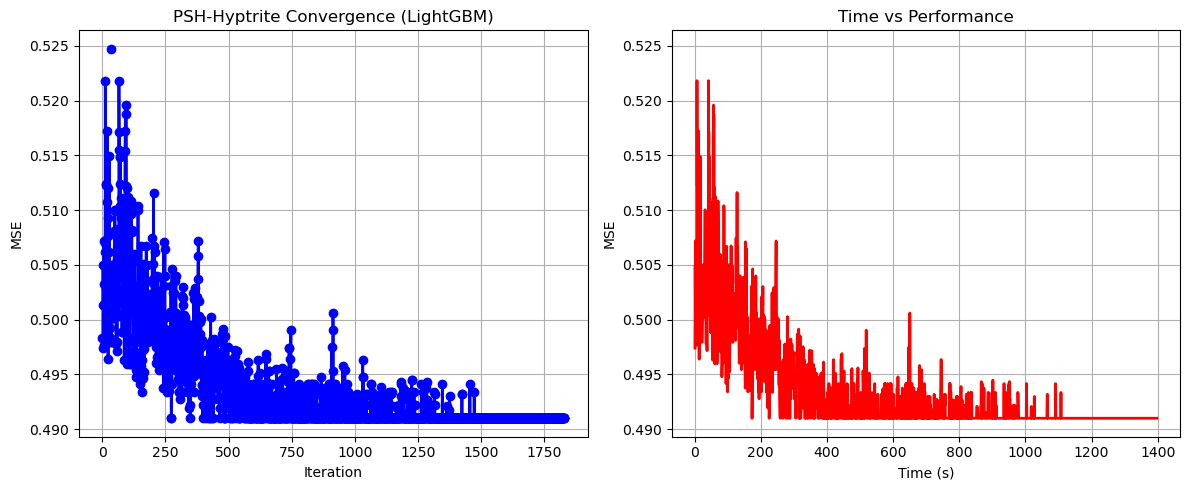

PSH-Hyptrite completed successfully with MSE: 0.4910


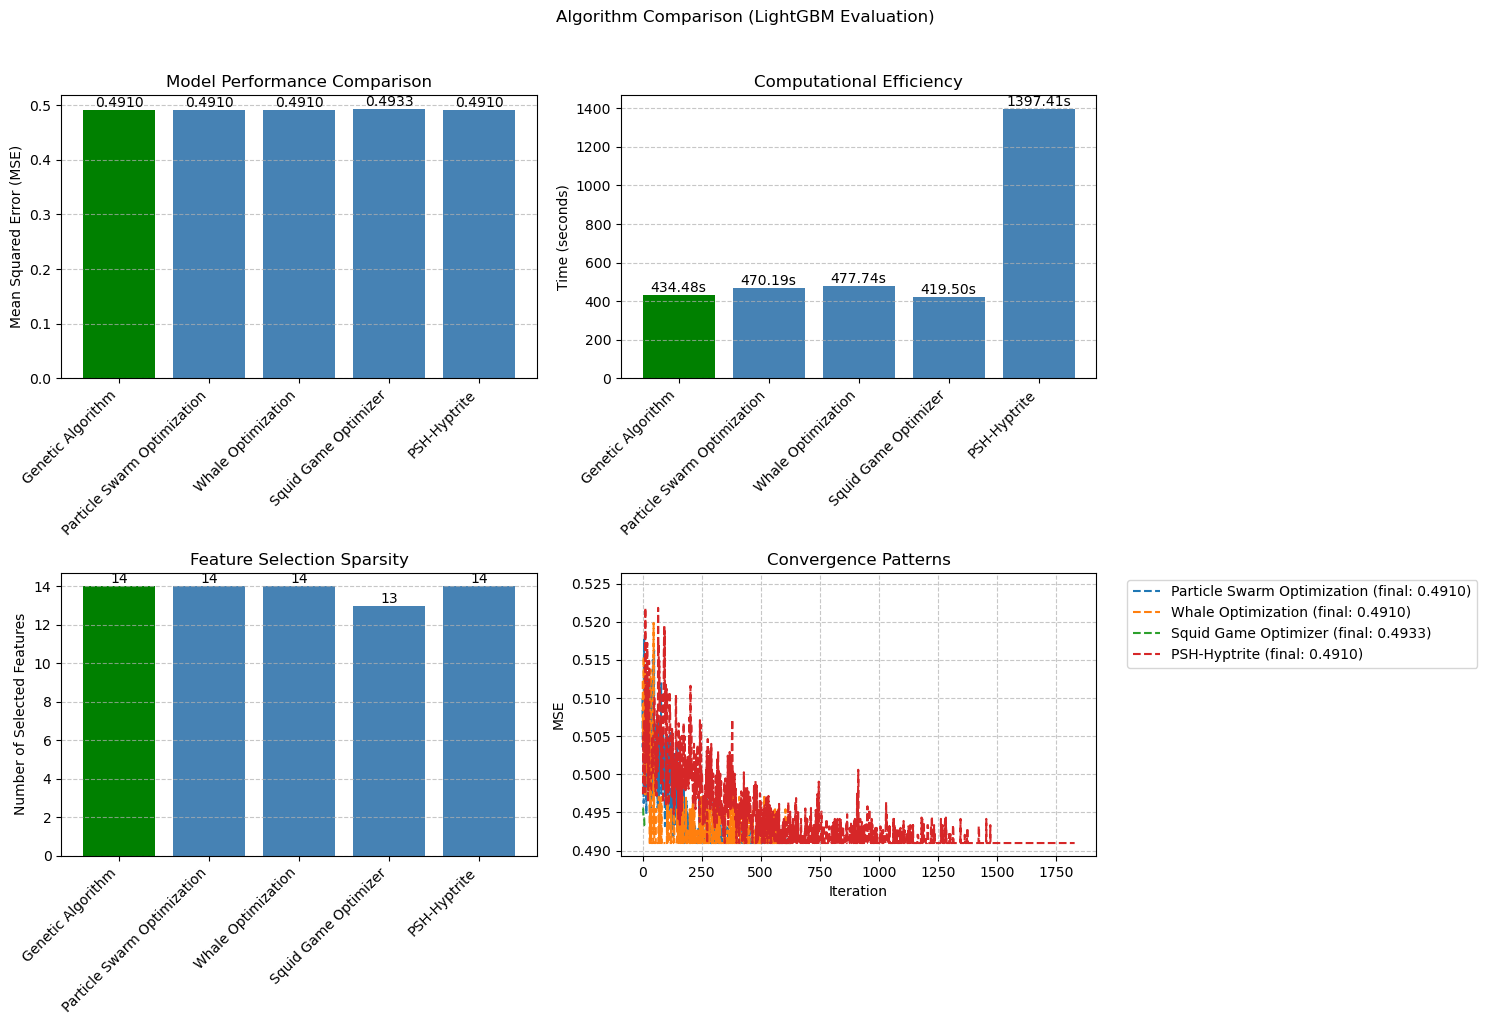


=== FINAL FEATURE SELECTION RESULTS USING LightGBM ===

🏆 BEST ALGORITHM: GENETIC ALGORITHM
   • MSE: 0.490991
   • Time: 434.48 seconds
   • Features: 14/14 (0.0% reduction)

📊 COMPARISON TABLE:
Algorithm                     MSE            Time (s)       Features       
---------------------------------------------------------------------------
Genetic Algorithm             0.490991       434.48         14             
Particle Swarm Optimization   0.490991       470.19         14             
Whale Optimization            0.490991       477.74         14             
PSH-Hyptrite                  0.490991       1397.41        14             
Squid Game Optimizer          0.493343       419.50         13             

🔍 SELECTED FEATURES:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. 10
12. 11
13. 12
14. 13

💡 Tip: Consider feature importance from LightGBM for further analysis


In [66]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)